In [1]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.append('../src')
from datagen import DataGenerator
%matplotlib inline

from sklearn.metrics import confusion_matrix
from matplotlib import cm
import seaborn as sns

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv1D, \
                                    Conv2D, BatchNormalization, MaxPooling1D, \
                                    GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers

In [90]:
# Build model
model = Sequential()

model.add(Conv2D(32, (9, 9), input_shape = (128, 640, 1), 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 2, activation = 'softmax'))

opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 640, 32)      2624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 320, 32)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 320, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 316, 64)       51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 314, 128)      73856     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)              

### Save best model and Reduce LR

In [92]:
# checkpoint_callback = ModelCheckpoint('../models/model2_with_datagen_best_val_loss.h5', 
#                                       monitor='val_loss', mode='min',
#                                       save_best_only=True, verbose=1)

reducelr_callback = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.8, 
                                      patience=2, min_delta=0.005, verbose=1)

callbacks_list = [reducelr_callback]

In [93]:
train_datagen = DataGenerator('data/training', include=['Rock', 'Hip-Hop'], 
                              batch_size=64, dim=(128,640), 
                              n_channels=1, test=False)

In [94]:
valid_datagen = DataGenerator('data/validation', include=['Rock', 'Hip-Hop'],
                              batch_size=16, dim=(128,640), 
                              n_channels=1, test=False)

In [95]:
test_datagen = DataGenerator('data/test', include=['Rock', 'Hip-Hop'],
                             batch_size=1, dim=(128,640), 
                             n_channels=1, test=True)

In [96]:
history = model.fit_generator(generator=train_datagen, epochs=5,
                              validation_data=valid_datagen, verbose=1, 
                              callbacks=callbacks_list)

Epoch 1/5
24/24 [==============================] - 18s 739ms/step - loss: 0.6910 - accuracy: 0.5007 - val_loss: 0.6882 - val_accuracy: 0.5052
Epoch 2/5
24/24 [==============================] - 15s 631ms/step - loss: 0.6909 - accuracy: 0.5085 - val_loss: 0.6888 - val_accuracy: 0.7292
Epoch 3/5
24/24 [==============================] - 15s 628ms/step - loss: 0.6588 - accuracy: 0.6055 - val_loss: 0.6782 - val_accuracy: 0.5312
Epoch 4/5
24/24 [==============================] - 15s 626ms/step - loss: 0.5776 - accuracy: 0.7168 - val_loss: 0.6365 - val_accuracy: 0.6146
Epoch 5/5
24/24 [==============================] - 15s 632ms/step - loss: 0.5504 - accuracy: 0.7311 - val_loss: 0.5293 - val_accuracy: 0.7812


In [97]:
model.save_weights('models/test.h5')

### Save model

In [98]:
def save_model_to_json(model, fpath):
    model_json = model.to_json()
    with open(fpath, "w") as json_file:
        json_file.write(model_json)

In [99]:
save_model_to_json(model, 'models/test.json')

### Load

In [109]:
def load_compile_model(json_path, weights_path, opt='adam'):
    with open(json_path, 'r') as json_file:
        loaded_json = json_file.read()
    loaded = model_from_json(loaded_json)
    loaded.load_weights(weights_path)
    loaded.compile(loss='categorical_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
    return loaded

In [110]:
loaded = load_compile_model('models/test.json', 'models/test.h5', opt='adam')

## Create functions to save visuals

In [58]:
import matplotlib.pyplot as plt

def save_summary_plots(history, fpath='plt.png', dpi=200):
    fig, axes = plt.subplots(1, 2, figsize=(13,5))
    ax1, ax2 = axes.flatten()
    
    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='best')

    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='best')
    
    plt.subplots_adjust(wspace=0.3)

    plt.savefig(fpath, dpi=dpi)


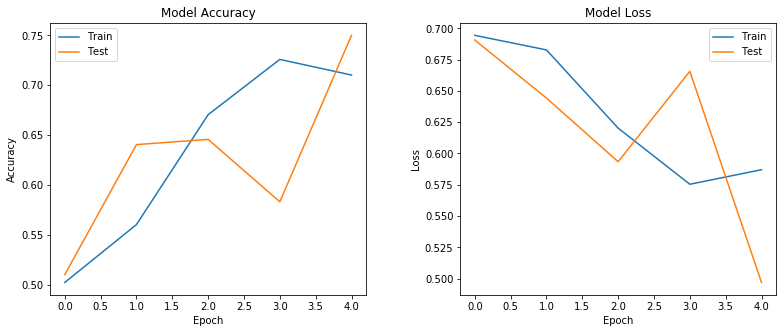

In [59]:
save_summary_plots(history, fpath='test.png')

In [76]:
def get_true_pred_targets(model, test_datagen):
    y_pred = model.predict_generator(test_datagen)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = test_datagen.test_labels
    y_true = np.argmax(y_true, axis=1)

    target_names = sorted(test_datagen.label_dict.keys())
    return y_true, y_pred, target_names

In [77]:
y_true, y_pred, target_names = get_true_pred_targets(model, test_datagen)

In [78]:
def save_confusion_matrix(y_true, y_pred, target_names, fpath='cm.png', dpi=200):
    fig, ax = plt.subplots(figsize=(6,6))
    
    mat = confusion_matrix(y_true, y_pred)

    sns.heatmap(mat.T, square=True, annot=True, fmt='d', 
                cbar=True, cmap=cm.Reds,
                xticklabels=target_names,
                yticklabels=target_names,
                ax=ax)

    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel('Actual', size=15)
    plt.ylabel('Predicted', size=15)
    plt.savefig(fpath, dpi=dpi)

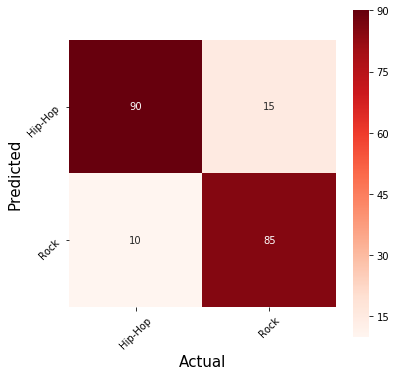

In [79]:
save_confusion_matrix(y_true, y_pred, target_names, fpath='cm.png')

### Functions to save metrics and hyperparams

In [74]:
acc = model.evaluate_generator(test_datagen)[1]

In [75]:
acc

0.875

In [81]:
from sklearn.metrics import classification_report

classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

{'Hip-Hop': {'precision': 0.8571428571428571,
  'recall': 0.9,
  'f1-score': 0.8780487804878048,
  'support': 100},
 'Rock': {'precision': 0.8947368421052632,
  'recall': 0.85,
  'f1-score': 0.8717948717948718,
  'support': 100},
 'accuracy': 0.875,
 'macro avg': {'precision': 0.8759398496240601,
  'recall': 0.875,
  'f1-score': 0.8749218261413383,
  'support': 200},
 'weighted avg': {'precision': 0.8759398496240601,
  'recall': 0.875,
  'f1-score': 0.8749218261413384,
  'support': 200}}

## Scrap

In [121]:
subdirs = sorted(os.listdir(filepath))
labels = np.arange(len(subdirs))

In [124]:
{k:v for k,v in zip(subdirs, labels)}

{'Hip-Hop': 0, 'Instrumental': 1, 'Rock': 2}

In [72]:
label_dict = {
    'Rock': 0,
    'Instrumental': 1,    
    'Hip-Hop': 2,
    'Folk': 3,
    'International': 4,            
    'Electronic': 5,
    'Experimental': 6,   
    'Pop': 7 
}

In [73]:
len(label_dict)

8

In [97]:
# Create list of filenames in a directory

filepath = 'data/test'
def __get_files(filepath):
    subdirs = os.listdir(filepath)
    all_files = []

    for subdir in subdirs:
        full_dir = os.path.join(filepath, subdir)
        files = os.listdir(full_dir)
        for file in files:
            all_files.append(os.path.join(subdir, file))

    return np.array(all_files)

In [98]:
all_files = __get_files(filepath)

In [101]:
idxs = [0,33,99]
all_files[idxs]

array(['Hip-Hop/132117.npy', 'Hip-Hop/110771.npy', 'Hip-Hop/140626.npy'],
      dtype='<U23')

In [105]:
batch_size = 5

npy = np.load(os.path.join(filepath, all_files[0]))
shape = npy.shape

channels = 1
n_classes = 2

In [112]:
def __data_generation(all_files):
    X = np.empty((batch_size, *shape, channels))
    y = np.empty((batch_size), dtype=int)
    
    for i, file in enumerate(all_files[:batch_size]):
        npy = np.load(os.path.join(filepath, file))
        target = file.split('/')[0]
        label = label_dict[target]
        X[i,] = npy[:,:,None]
        y[i,] = label
    
    return X, y
# to_categorical(y, num_classes=n_classes, dtype='int')

In [113]:
X, y = __data_generation(all_files)

In [114]:
y

array([2, 2, 2, 2, 2])

In [119]:
to_categorical(y, num_classes=5)

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [108]:
X = np.empty((batch_size, *shape, channels))

In [109]:
all_files[0].split('/')[0]

'Hip-Hop'